In [1]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
from tsxv.splitTrainValTest import split_train_val_test_forwardChaining
import matplotlib.pyplot as plt
import optuna

In [2]:
data = pd.read_csv('BrentOilPrices.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.resample('M').mean()
data = data.reset_index()

In [3]:
input_train, forecast_train, input_val, forecast_val, input_test, forecast_test = split_train_val_test_forwardChaining(
    data['Date'], numInputs=60, numOutputs=24, numJumps=24)
data = data.set_index('Date')
data.index.freq = 'M'

## Moving Average (MA)

Moving averages are mostly used for analysis, instead of using it solely for forecasting. 

Formula for simple moving average:

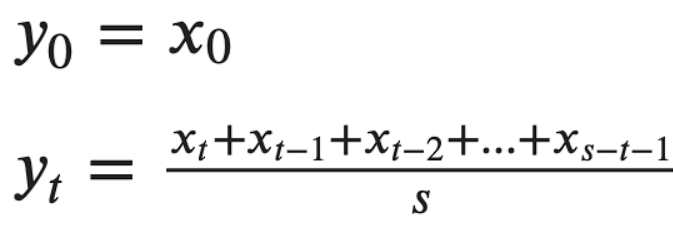

Rolling function in Pandas can be used for computing moving averages during analysis.

Equation of MA model:

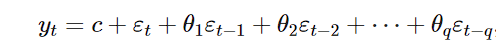

The equation above represents MA model, which is a regression-like model consist of current value of series against current and previous (observed) white noise error terms or random shocks. <b>White noise error terms are assumed to follow standard normal distribution</b>.

MA model is mostly used to forecast values

Note that MA provides similar importance to all observations and it is more suitable for time series data that has no trend and no seasonality.

## AutoRegression (AR)

Autoregression represents linear combination of past values, including white noise error term.

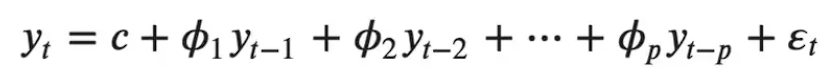

AR model is mostly used to forecast errors

## Invertibility of Time Series

A time series is invertible if errors can be inverted into a representation of past observations.

MA(1) model is equivalent to AR(infinity) model when absolute value of phi coefficient is less than 1. This becomes handy when there is only information of past lagged values, instead of past error terms for MA model.

AR(1) model is equivalent to MA(infinity) model when absolute value of phi coefficient is less than 1. This becomes handy when there is only information of past error terms, instead of past lagged values for AR model.

## Autoregressive Integrated Moving Average (ARIMA)

ARIMA model represents combination of AR and MA model with differencing component, I included to make time series stationary.

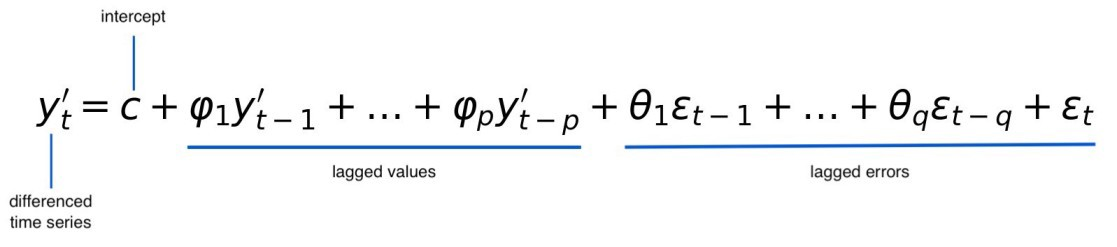

<b>Assumptions of ARIMA</b>: Time series data is stationary

<b>Advantages of ARIMA</b>:
1. Suitable for short term forecast

<b>Disadvantages of ARIMA</b>:
1. Does not cover seasonal component
2. Difficult to predict turning points
3. Computationally expensive

<b>Important hyperparameters of ARIMA</b>
1. p: Autoregression order
2. d: Differencing order
3. q: Moving average order
4. trend: Type of trend component

In [4]:
def arima_objective(trial, train_data, val_data=None):
    p = trial.suggest_int('p',0,10)
    q = trial.suggest_int('q',0,10)
    trend = trial.suggest_categorical('trend',['n','c','t','ct'])
    reg = SARIMAX(endog=train_data, order=(p,1,q), initialization='approximate_diffuse', freq='M',trend=trend)
    reg = reg.fit(disp=0, maxiter=1000)
    if val_data is not None:
        yhat = reg.forecast(len(val_data))
        val_mape = mean_absolute_percentage_error(val_data,yhat)
    else:
        yhat = reg.predict(start=0, end=len(train_data)-1)
        val_mape = mean_absolute_percentage_error(train_data,yhat)
    return val_mape

In [5]:
avg_val_mape, avg_test_mape = [], []
for fold in range(len(input_train)):
    input_sub_train_data = data.loc[list(input_train[fold].ravel())].drop_duplicates()
    input_sub_train_data.index.freq = 'M'
    input_sub_val_data = data.loc[list(input_val[fold].ravel())].drop_duplicates()
    input_sub_val_data.index.freq = 'M'
    input_sub_test_data = data.loc[list(input_test[fold].ravel())].drop_duplicates()
    input_sub_test_data.index.freq = 'M'
    func = lambda trial: arima_objective(trial, input_sub_train_data, input_sub_val_data)
    sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
    study = optuna.create_study(direction='minimize',sampler=sampler)
    study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
    trial = study.best_trial
    reg = SARIMAX(endog=pd.concat([input_sub_train_data,input_sub_val_data]), order=(trial.params['p'],1,trial.params['q']), 
                  initialization='approximate_diffuse', freq='M',trend=trial.params['trend'])
    reg = reg.fit(disp=0, maxiter=1000)
    yhat = reg.forecast(len(input_sub_test_data))
    test_mape = mean_absolute_percentage_error(input_sub_test_data,yhat)
    print()
    print(f'Best hyperparameters identified for fold {fold+1}: {trial.params}')
    print(f'Validation MAPE for fold {fold+1} : {trial.value}')
    print(f'Test MAPE for fold {fold+1} : {test_mape}')
    print()
    avg_val_mape.append(trial.value)
    avg_test_mape.append(test_mape)
print('---------')
print(f'Average validation MAPE: {np.mean(avg_val_mape)}')
print(f'Average test MAPE: {np.mean(avg_test_mape)}')

[I 2022-11-12 08:21:57,716] A new study created in memory with name: no-name-46b35568-e4e6-48dc-abd2-6c2e1cc7c396


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:22:00,356] Trial 0 finished with value: 1.138978354917857 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 1.138978354917857.


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:22:11,482] Trial 1 finished with value: 0.1651162685327928 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 1 with value: 0.1651162685327928.
[I 2022-11-12 08:22:18,102] Trial 2 finished with value: 1.0961053809508834 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 1 with value: 0.1651162685327928.
[I 2022-11-12 08:22:18,573] Trial 3 finished with value: 0.5847898055171813 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.1651162685327928.
[I 2022-11-12 08:22:18,992] Trial 4 finished with value: 0.1797686587015156 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 1 with value: 0.1651162685327928.
[I 2022-11-12 08:22:19,700] Trial 5 finished with value: 0.16784396539617347 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Best is trial 1 with value: 0.1651162685327928.
[I 2022-11-12 08:22:20,282] Trial 6 finished with value: 0.19094487985151473 and parameters: {'p': 1, 'q': 6, 'trend': 'n'}. Best is tr

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:22:20,537] Trial 7 finished with value: 0.1375492913543523 and parameters: {'p': 2, 'q': 2, 'trend': 't'}. Best is trial 7 with value: 0.1375492913543523.
[I 2022-11-12 08:22:25,964] Trial 8 finished with value: 1.4827394334614565 and parameters: {'p': 8, 'q': 8, 'trend': 'ct'}. Best is trial 7 with value: 0.1375492913543523.
[I 2022-11-12 08:22:28,149] Trial 9 finished with value: 0.20761686801357412 and parameters: {'p': 3, 'q': 7, 'trend': 'c'}. Best is trial 7 with value: 0.1375492913543523.


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:22:28,743] Trial 10 finished with value: 0.13933721814163555 and parameters: {'p': 1, 'q': 3, 'trend': 't'}. Best is trial 7 with value: 0.1375492913543523.
[I 2022-11-12 08:22:28,899] Trial 11 finished with value: 0.26080467821163217 and parameters: {'p': 0, 'q': 1, 'trend': 't'}. Best is trial 7 with value: 0.1375492913543523.
[I 2022-11-12 08:22:29,478] Trial 12 finished with value: 0.3467866019221295 and parameters: {'p': 4, 'q': 3, 'trend': 't'}. Best is trial 7 with value: 0.1375492913543523.
[I 2022-11-12 08:22:29,905] Trial 13 finished with value: 0.31875681057529376 and parameters: {'p': 0, 'q': 5, 'trend': 't'}. Best is trial 7 with value: 0.1375492913543523.
[I 2022-11-12 08:22:30,131] Trial 14 finished with value: 1.1071689569435144 and parameters: {'p': 1, 'q': 3, 'trend': 'ct'}. Best is trial 7 with value: 0.1375492913543523.
[I 2022-11-12 08:22:30,282] Trial 15 finished with value: 0.16594268169191276 and parameters: {'p': 3, 'q': 0, 'trend': 'n'}. Best 

[I 2022-11-12 08:22:42,538] A new study created in memory with name: no-name-014e4e73-6954-4421-806f-12abfdafd226



Best hyperparameters identified for fold 1: {'p': 2, 'q': 2, 'trend': 't'}
Validation MAPE for fold 1 : 0.1375492913543523
Test MAPE for fold 1 : 0.489676239700812



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:22:47,307] Trial 0 finished with value: 0.27460136070744695 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 0.27460136070744695.


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:23:00,432] Trial 1 finished with value: 0.2674323338890829 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 1 with value: 0.2674323338890829.
[I 2022-11-12 08:23:02,944] Trial 2 finished with value: 0.36713739480646457 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 1 with value: 0.2674323338890829.
[I 2022-11-12 08:23:03,277] Trial 3 finished with value: 0.3059328190901793 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.2674323338890829.
[I 2022-11-12 08:23:03,943] Trial 4 finished with value: 0.2756674361093941 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 1 with value: 0.2674323338890829.
[I 2022-11-12 08:23:07,043] Trial 5 finished with value: 0.26868809176200537 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Best is trial 1 with value: 0.2674323338890829.
[I 2022-11-12 08:23:07,657] Trial 6 finished with value: 0.26890879680052754 and parameters: {'p': 1, 'q': 6, 'trend': 'n'}. Best is t

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:23:50,843] Trial 15 finished with value: 0.26943571403301714 and parameters: {'p': 8, 'q': 9, 'trend': 't'}. Best is trial 11 with value: 0.2664897536973119.
[I 2022-11-12 08:23:58,166] Trial 16 finished with value: 0.2680596291276502 and parameters: {'p': 7, 'q': 10, 'trend': 'n'}. Best is trial 11 with value: 0.2664897536973119.
[I 2022-11-12 08:24:04,863] Trial 17 finished with value: 0.2687124833462616 and parameters: {'p': 10, 'q': 4, 'trend': 'c'}. Best is trial 11 with value: 0.2664897536973119.
[I 2022-11-12 08:24:05,568] Trial 18 finished with value: 0.27410389316668354 and parameters: {'p': 9, 'q': 1, 'trend': 'n'}. Best is trial 11 with value: 0.2664897536973119.
[I 2022-11-12 08:24:17,427] Trial 19 finished with value: 0.4788525790177362 and parameters: {'p': 10, 'q': 10, 'trend': 'ct'}. Best is trial 11 with value: 0.2664897536973119.


[I 2022-11-12 08:24:30,324] A new study created in memory with name: no-name-196b1716-f653-43a3-93e6-9c7acc1eb6fc



Best hyperparameters identified for fold 2: {'p': 9, 'q': 10, 'trend': 'n'}
Validation MAPE for fold 2 : 0.2664897536973119
Test MAPE for fold 2 : 0.3838571091924898



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:24:34,283] Trial 0 finished with value: 0.5808295726796115 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 0.5808295726796115.
[I 2022-11-12 08:24:47,287] Trial 1 finished with value: 0.30872579499846625 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 1 with value: 0.30872579499846625.
[I 2022-11-12 08:24:50,896] Trial 2 finished with value: 0.4421414622125096 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 1 with value: 0.30872579499846625.
[I 2022-11-12 08:24:51,482] Trial 3 finished with value: 0.5137840267137538 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.30872579499846625.
[I 2022-11-12 08:24:51,873] Trial 4 finished with value: 0.37081608749996003 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 1 with value: 0.30872579499846625.
[I 2022-11-12 08:24:52,985] Trial 5 finished with value: 0.31143539615918303 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Best

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:25:50,765] Trial 19 finished with value: 0.44340271219250416 and parameters: {'p': 10, 'q': 10, 'trend': 'ct'}. Best is trial 12 with value: 0.30808990645755613.


[I 2022-11-12 08:26:04,708] A new study created in memory with name: no-name-a10724f3-b336-43e2-817b-6ad8e2015114



Best hyperparameters identified for fold 3: {'p': 9, 'q': 10, 'trend': 'n'}
Validation MAPE for fold 3 : 0.30808990645755613
Test MAPE for fold 3 : 0.546259476317274



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:26:10,118] Trial 0 finished with value: 0.385195883689134 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 0.385195883689134.
[I 2022-11-12 08:26:24,760] Trial 1 finished with value: 0.35902828909227796 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 1 with value: 0.35902828909227796.
[I 2022-11-12 08:26:29,897] Trial 2 finished with value: 0.37506260871723035 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 1 with value: 0.35902828909227796.
[I 2022-11-12 08:26:30,621] Trial 3 finished with value: 0.17192594452468943 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 3 with value: 0.17192594452468943.
[I 2022-11-12 08:26:31,066] Trial 4 finished with value: 0.23918618196296304 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 3 with value: 0.17192594452468943.
[I 2022-11-12 08:26:32,641] Trial 5 finished with value: 0.3740744789235681 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Best 

[I 2022-11-12 08:27:54,987] A new study created in memory with name: no-name-aae90f4c-4e27-42e1-8d22-6371cad2dc2d



Best hyperparameters identified for fold 4: {'p': 8, 'q': 8, 'trend': 'ct'}
Validation MAPE for fold 4 : 0.1422371585501549
Test MAPE for fold 4 : 0.21523546598186213



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:28:09,243] Trial 0 finished with value: 0.3384318608447224 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 0.3384318608447224.
[I 2022-11-12 08:28:20,735] Trial 1 finished with value: 0.4815750389721482 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 0 with value: 0.3384318608447224.
[I 2022-11-12 08:28:35,188] Trial 2 finished with value: 0.3408368969661716 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 0 with value: 0.3384318608447224.
[I 2022-11-12 08:28:35,553] Trial 3 finished with value: 0.3275247859748791 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 3 with value: 0.3275247859748791.
[I 2022-11-12 08:28:36,329] Trial 4 finished with value: 0.3842053645000956 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 3 with value: 0.3275247859748791.
[I 2022-11-12 08:28:37,049] Trial 5 finished with value: 0.40261075283730763 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Best is tr

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:28:55,335] Trial 8 finished with value: 0.34804168002507446 and parameters: {'p': 8, 'q': 8, 'trend': 'ct'}. Best is trial 3 with value: 0.3275247859748791.
[I 2022-11-12 08:28:56,011] Trial 9 finished with value: 0.3814409091968283 and parameters: {'p': 3, 'q': 7, 'trend': 'c'}. Best is trial 3 with value: 0.3275247859748791.
[I 2022-11-12 08:28:56,658] Trial 10 finished with value: 0.3467165319105652 and parameters: {'p': 8, 'q': 0, 'trend': 'ct'}. Best is trial 3 with value: 0.3275247859748791.
[I 2022-11-12 08:28:57,100] Trial 11 finished with value: 0.24356843698141808 and parameters: {'p': 2, 'q': 0, 'trend': 'ct'}. Best is trial 11 with value: 0.24356843698141808.
[I 2022-11-12 08:28:57,417] Trial 12 finished with value: 0.25394658858206104 and parameters: {'p': 3, 'q': 0, 'trend': 'ct'}. Best is trial 11 with value: 0.24356843698141808.
[I 2022-11-12 08:28:58,160] Trial 13 finished with value: 0.28603594093573587 and parameters: {'p': 2, 'q': 3, 'trend': 'ct'}.

[I 2022-11-12 08:29:07,158] A new study created in memory with name: no-name-619b08d5-81e6-435b-87d2-253c4e0fb63e



Best hyperparameters identified for fold 5: {'p': 2, 'q': 0, 'trend': 'ct'}
Validation MAPE for fold 5 : 0.24356843698141808
Test MAPE for fold 5 : 0.2316405836769589



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:29:12,056] Trial 0 finished with value: 0.3550811222811455 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 0.3550811222811455.
[I 2022-11-12 08:29:30,619] Trial 1 finished with value: 0.489388420858617 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 0 with value: 0.3550811222811455.
[I 2022-11-12 08:29:39,256] Trial 2 finished with value: 0.36695532515260265 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 0 with value: 0.3550811222811455.
[I 2022-11-12 08:29:39,642] Trial 3 finished with value: 0.34993543697615903 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 3 with value: 0.34993543697615903.
[I 2022-11-12 08:29:40,263] Trial 4 finished with value: 0.430370801567073 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 3 with value: 0.34993543697615903.
[I 2022-11-12 08:29:40,716] Trial 5 finished with value: 0.4652117043923129 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Best is t

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2022-11-12 08:29:59,586] A new study created in memory with name: no-name-823eaae7-a5db-4d2b-890c-68cd97c3e11a



Best hyperparameters identified for fold 6: {'p': 2, 'q': 2, 'trend': 't'}
Validation MAPE for fold 6 : 0.318021240981813
Test MAPE for fold 6 : 0.1184143538938986



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:30:10,808] Trial 0 finished with value: 0.3372501628008925 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 0.3372501628008925.
[I 2022-11-12 08:30:19,263] Trial 1 finished with value: 0.4037639929116784 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 0 with value: 0.3372501628008925.
[I 2022-11-12 08:30:34,190] Trial 2 finished with value: 0.36595541088787725 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 0 with value: 0.3372501628008925.
[I 2022-11-12 08:30:35,140] Trial 3 finished with value: 0.3413930267683553 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 0 with value: 0.3372501628008925.
[I 2022-11-12 08:30:36,558] Trial 4 finished with value: 0.20497944634666787 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 4 with value: 0.20497944634666787.
[I 2022-11-12 08:30:36,929] Trial 5 finished with value: 0.19868393238475146 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Best is

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:30:57,832] Trial 8 finished with value: 0.3637685149650264 and parameters: {'p': 8, 'q': 8, 'trend': 'ct'}. Best is trial 5 with value: 0.19868393238475146.
[I 2022-11-12 08:31:02,840] Trial 9 finished with value: 0.19600177880409397 and parameters: {'p': 3, 'q': 7, 'trend': 'c'}. Best is trial 9 with value: 0.19600177880409397.
[I 2022-11-12 08:31:03,078] Trial 10 finished with value: 0.19877089394571937 and parameters: {'p': 0, 'q': 5, 'trend': 'c'}. Best is trial 9 with value: 0.19600177880409397.
[I 2022-11-12 08:31:03,632] Trial 11 finished with value: 0.19876605328382946 and parameters: {'p': 2, 'q': 10, 'trend': 'n'}. Best is trial 9 with value: 0.19600177880409397.
[I 2022-11-12 08:31:07,488] Trial 12 finished with value: 0.19578302485571383 and parameters: {'p': 4, 'q': 7, 'trend': 'c'}. Best is trial 12 with value: 0.19578302485571383.
[I 2022-11-12 08:31:13,463] Trial 13 finished with value: 0.19725893279491913 and parameters: {'p': 4, 'q': 8, 'trend': 'c'}.

[I 2022-11-12 08:31:50,280] A new study created in memory with name: no-name-85fe5b0c-4348-417b-84d4-88e3c04c28b5



Best hyperparameters identified for fold 7: {'p': 4, 'q': 7, 'trend': 'c'}
Validation MAPE for fold 7 : 0.19578302485571383
Test MAPE for fold 7 : 0.3997949709084164



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:32:01,039] Trial 0 finished with value: 0.7079968857276863 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 0.7079968857276863.
[I 2022-11-12 08:32:15,400] Trial 1 finished with value: 0.7356848880463088 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 0 with value: 0.7079968857276863.
[I 2022-11-12 08:32:27,858] Trial 2 finished with value: 0.7185760748790275 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 0 with value: 0.7079968857276863.
[I 2022-11-12 08:32:28,294] Trial 3 finished with value: 0.7128325658866214 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 0 with value: 0.7079968857276863.
[I 2022-11-12 08:32:28,824] Trial 4 finished with value: 0.4238602783470559 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 4 with value: 0.4238602783470559.
[I 2022-11-12 08:32:29,240] Trial 5 finished with value: 0.4965720045551151 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Best is tri

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:32:51,882] Trial 8 finished with value: 0.6455785749591184 and parameters: {'p': 8, 'q': 8, 'trend': 'ct'}. Best is trial 6 with value: 0.3315055171200056.
[I 2022-11-12 08:32:52,835] Trial 9 finished with value: 0.5352959931940695 and parameters: {'p': 3, 'q': 7, 'trend': 'c'}. Best is trial 6 with value: 0.3315055171200056.
[I 2022-11-12 08:32:52,991] Trial 10 finished with value: 0.33679865114645663 and parameters: {'p': 0, 'q': 4, 'trend': 'n'}. Best is trial 6 with value: 0.3315055171200056.
[I 2022-11-12 08:32:53,887] Trial 11 finished with value: 0.7143849976128309 and parameters: {'p': 0, 'q': 5, 'trend': 'ct'}. Best is trial 6 with value: 0.3315055171200056.
[I 2022-11-12 08:32:54,042] Trial 12 finished with value: 0.335840499497375 and parameters: {'p': 0, 'q': 3, 'trend': 'n'}. Best is trial 6 with value: 0.3315055171200056.
[I 2022-11-12 08:32:55,088] Trial 13 finished with value: 0.7797723694558452 and parameters: {'p': 3, 'q': 5, 'trend': 'n'}. Best is tr

In [6]:
func = lambda trial: arima_objective(trial, data)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial

[I 2022-11-12 08:33:02,333] A new study created in memory with name: no-name-30eabf89-1b58-4f33-8e2a-02a0db88dc12


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:33:05,848] Trial 0 finished with value: 0.07318349379646191 and parameters: {'p': 7, 'q': 5, 'trend': 'ct'}. Best is trial 0 with value: 0.07318349379646191.
[I 2022-11-12 08:33:29,662] Trial 1 finished with value: 0.07234224682347903 and parameters: {'p': 10, 'q': 9, 'trend': 'n'}. Best is trial 1 with value: 0.07234224682347903.
[I 2022-11-12 08:33:43,344] Trial 2 finished with value: 0.07342758144223178 and parameters: {'p': 7, 'q': 7, 'trend': 'ct'}. Best is trial 1 with value: 0.07234224682347903.
[I 2022-11-12 08:33:44,296] Trial 3 finished with value: 0.0727922136615764 and parameters: {'p': 5, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.07234224682347903.
[I 2022-11-12 08:33:45,628] Trial 4 finished with value: 0.07330190608139137 and parameters: {'p': 5, 'q': 2, 'trend': 'c'}. Best is trial 1 with value: 0.07234224682347903.
[I 2022-11-12 08:33:46,188] Trial 5 finished with value: 0.0713606191947819 and parameters: {'p': 1, 'q': 10, 'trend': 'n'}. Be

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:34:06,549] Trial 8 finished with value: 0.0729719894753445 and parameters: {'p': 8, 'q': 8, 'trend': 'ct'}. Best is trial 5 with value: 0.0713606191947819.
[I 2022-11-12 08:34:07,956] Trial 9 finished with value: 0.07405923665021445 and parameters: {'p': 3, 'q': 7, 'trend': 'c'}. Best is trial 5 with value: 0.0713606191947819.
[I 2022-11-12 08:34:13,224] Trial 10 finished with value: 0.07134246827152858 and parameters: {'p': 1, 'q': 10, 'trend': 't'}. Best is trial 10 with value: 0.07134246827152858.
[I 2022-11-12 08:34:15,750] Trial 11 finished with value: 0.07126531521628786 and parameters: {'p': 0, 'q': 10, 'trend': 't'}. Best is trial 11 with value: 0.07126531521628786.
[I 2022-11-12 08:34:32,195] Trial 12 finished with value: 0.0724246660803697 and parameters: {'p': 4, 'q': 10, 'trend': 't'}. Best is trial 11 with value: 0.07126531521628786.
[I 2022-11-12 08:34:33,206] Trial 13 finished with value: 0.07207093621452607 and parameters: {'p': 0, 'q': 8, 'trend': 't'}

In [7]:
reg = SARIMAX(endog=data, order=(trial.params['p'],1,trial.params['q']), initialization='approximate_diffuse', freq='M')
reg = reg.fit(disp=0, maxiter=1000)
pred_values = reg.predict(start=0, end=len(data)-1)

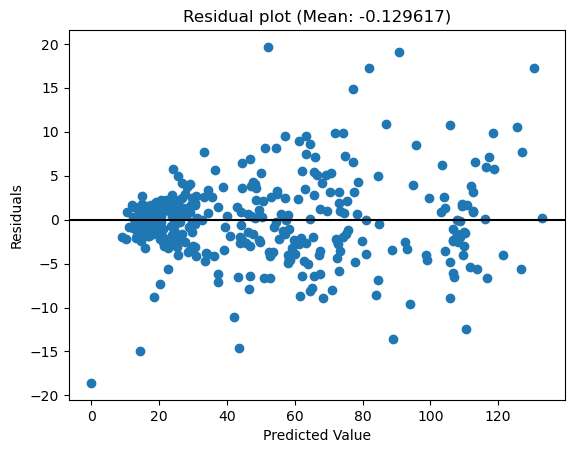

In [8]:
plt.scatter(x = pred_values, y= np.subtract(pred_values,data['Price']))
plt.axhline(y=0, color='black')
plt.title(f"Residual plot (Mean: {np.round(np.subtract(pred_values,data['Price']).mean(),6)})")
plt.ylabel('Residuals')
plt.xlabel('Predicted Value')
plt.show()

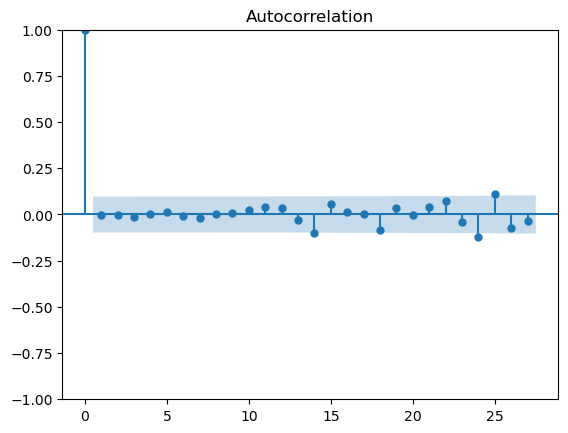

array([ 1.00000000e+00, -5.55690934e-04, -3.94303406e-03, -1.18691055e-02,
        7.07015348e-04,  1.35610359e-02, -9.35964330e-03, -2.00089515e-02,
        3.59963846e-03,  8.53044526e-03,  2.16748070e-02,  4.28335861e-02,
        3.39199823e-02, -3.12315550e-02, -1.02164693e-01,  5.71643035e-02,
        1.42984613e-02,  4.65007175e-03, -8.42743576e-02,  3.67151215e-02,
       -2.04481149e-03,  4.13441887e-02,  7.02660771e-02, -4.29386414e-02,
       -1.20041431e-01,  1.12696285e-01, -7.08056040e-02])

In [9]:
plot_acf(np.subtract(pred_values,data['Price']))
plt.show()
acf(np.subtract(pred_values,data['Price']))

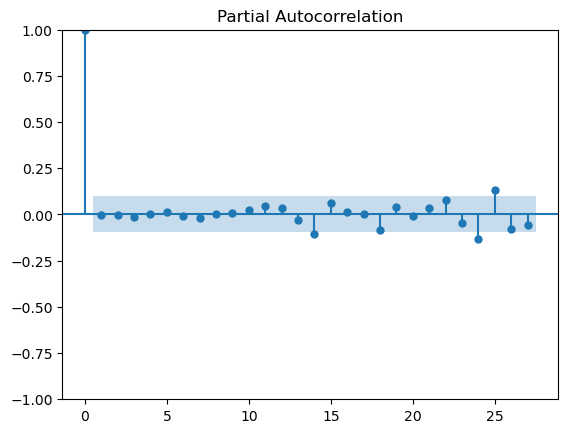

array([ 1.00000000e+00, -5.57066407e-04, -3.96291402e-03, -1.19622963e-02,
        6.84528547e-04,  1.36386990e-02, -9.62470070e-03, -2.02570453e-02,
        3.90559834e-03,  8.33969926e-03,  2.16185613e-02,  4.45562448e-02,
        3.60032978e-02, -3.18978426e-02, -1.05869947e-01,  5.97777269e-02,
        1.39021346e-02,  3.60537937e-03, -8.53842160e-02,  4.28537795e-02,
       -8.59462631e-03,  3.73257160e-02,  7.69855098e-02, -4.43715048e-02,
       -1.30489169e-01,  1.35067460e-01, -7.81467333e-02])

In [10]:
plot_pacf(np.subtract(pred_values,data['Price']))
plt.show()
pacf(np.subtract(pred_values,data['Price']))

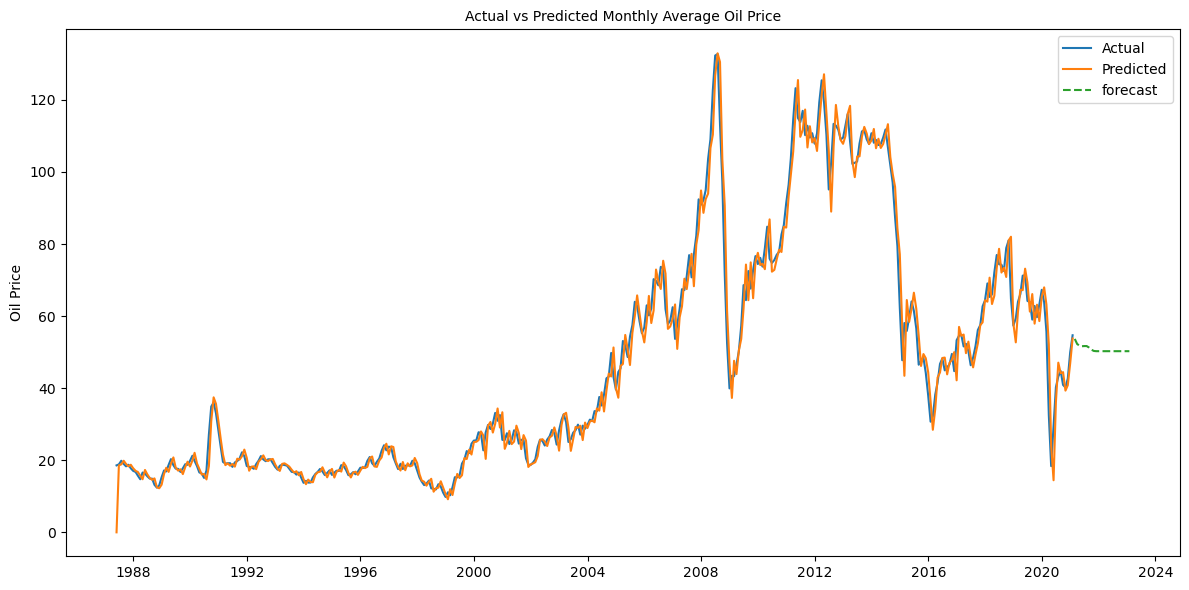

In [11]:
plt.figure(figsize=(12,6))
plt.plot(data, label='Actual')
plt.title('Actual vs Predicted Monthly Average Oil Price', fontsize=10)
pred_data = pd.DataFrame({'Date':data.reset_index()['Date'],'Price': pd.Series(pred_values.reset_index(drop=True))})
pred_data['Date'] = pd.to_datetime(pred_data['Date'])
pred_data = pred_data.set_index('Date')
plt.plot(pred_data, label='Predicted')
forecast_data = reg.forecast(24)
plt.plot(forecast_data, label='forecast',linestyle='--')
plt.legend(loc='best')
plt.ylabel("Oil Price")
plt.tight_layout()

## Seasonal Autoregressive Integrated Moving Average (SARIMA)

SARIMA or Seasonal ARIMA is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

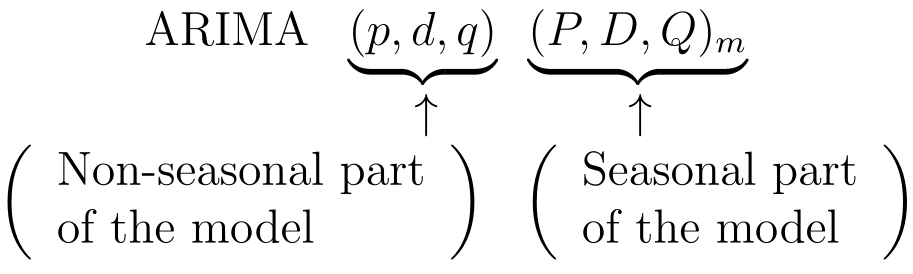

<b>Assumptions of SARIMA</b>: Time series data is stationary

<b>Advantages of SARIMA</b>:
1. Suitable for short term forecast
2. Accounts for seasonality

<b>Disadvantages of SARIMA</b>:
1. Difficult to predict turning points
2. Computationally expensive

<b>Important hyperparameters of SARIMA</b>
1. p: Autoregression order
2. d: Differencing order
3. q: Moving average order
4. P: Seasonal autoregression order
5. D: Seasonal differencing order
6. Q: Seasonal moving average order
7. m: Seasonal period
8. trend: Type of trend component

Note that exogeneous (external) variables can also be included in SARIMA model, which becomes SARIMAX models that considers external factors when performing time series forecasting.

In [12]:
def sarima_objective(trial, train_data, val_data=None):
    p = trial.suggest_int('p',0,2)
    q = trial.suggest_int('q',0,2)
    trend = trial.suggest_categorical('trend',['n','c','t','ct'])
    reg = SARIMAX(endog=train_data, order=(p,1,q), initialization='approximate_diffuse', freq='M',trend=trend, seasonal_order=(p,1,q,12))
    reg = reg.fit(disp=0, maxiter=1000)
    if val_data is not None:
        yhat = reg.forecast(len(val_data))
        val_mape = mean_absolute_percentage_error(val_data,yhat)
    else:
        yhat = reg.predict(start=0, end=len(train_data)-1)
        val_mape = mean_absolute_percentage_error(train_data,yhat)
    return val_mape

In [13]:
avg_val_mape, avg_test_mape = [], []
for fold in range(len(input_train)):
    input_sub_train_data = data.loc[list(input_train[fold].ravel())].drop_duplicates()
    input_sub_train_data.index.freq = 'M'
    input_sub_val_data = data.loc[list(input_val[fold].ravel())].drop_duplicates()
    input_sub_val_data.index.freq = 'M'
    input_sub_test_data = data.loc[list(input_test[fold].ravel())].drop_duplicates()
    input_sub_test_data.index.freq = 'M'
    func = lambda trial: sarima_objective(trial, input_sub_train_data, input_sub_val_data)
    sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
    study = optuna.create_study(direction='minimize',sampler=sampler)
    study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
    trial = study.best_trial
    reg = SARIMAX(endog=pd.concat([input_sub_train_data,input_sub_val_data]), order=(trial.params['p'],1,trial.params['q']), 
                  initialization='approximate_diffuse', freq='M',trend=trial.params['trend'], seasonal_order=(trial.params['p'],1,trial.params['q'],12))
    reg = reg.fit(disp=0, maxiter=1000)
    yhat = reg.forecast(len(input_sub_test_data))
    test_mape = mean_absolute_percentage_error(input_sub_test_data,yhat)
    print()
    print(f'Best hyperparameters identified for fold {fold+1}: {trial.params}')
    print(f'Validation MAPE for fold {fold+1} : {trial.value}')
    print(f'Test MAPE for fold {fold+1} : {test_mape}')
    print()
    avg_val_mape.append(trial.value)
    avg_test_mape.append(test_mape)
print('---------')
print(f'Average validation MAPE: {np.mean(avg_val_mape)}')
print(f'Average test MAPE: {np.mean(avg_test_mape)}')

[I 2022-11-12 08:35:07,392] A new study created in memory with name: no-name-4fdf72c4-3855-4884-ab97-2013aebfa357


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:35:12,832] Trial 0 finished with value: 0.8414255458833763 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 0.8414255458833763.
[I 2022-11-12 08:35:19,075] Trial 1 finished with value: 0.1746045923050312 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 1 with value: 0.1746045923050312.
[I 2022-11-12 08:35:24,857] Trial 2 finished with value: 2.234192482908923 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 1 with value: 0.1746045923050312.
[I 2022-11-12 08:35:25,573] Trial 3 finished with value: 1.931858028451677 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.1746045923050312.
[I 2022-11-12 08:35:25,949] Trial 4 finished with value: 0.3095782099017803 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 1 with value: 0.1746045923050312.
[I 2022-11-12 08:35:26,878] Trial 5 finished with value: 0.1909002394963903 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best is trial 1

[I 2022-11-12 08:35:53,564] A new study created in memory with name: no-name-249f919b-f412-471e-afc4-c64020ca87f5



Best hyperparameters identified for fold 1: {'p': 1, 'q': 1, 'trend': 'n'}
Validation MAPE for fold 1 : 0.16276049915910668
Test MAPE for fold 1 : 0.38653799253968946



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:36:02,598] Trial 0 finished with value: 1.4982459229403093 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 1.4982459229403093.
[I 2022-11-12 08:36:12,330] Trial 1 finished with value: 0.2622720350507258 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 1 with value: 0.2622720350507258.
[I 2022-11-12 08:36:18,058] Trial 2 finished with value: 0.7071854650174156 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 1 with value: 0.2622720350507258.
[I 2022-11-12 08:36:18,845] Trial 3 finished with value: 0.3226326075149216 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.2622720350507258.
[I 2022-11-12 08:36:19,280] Trial 4 finished with value: 0.45602078113044175 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 1 with value: 0.2622720350507258.
[I 2022-11-12 08:36:20,873] Trial 5 finished with value: 0.3114018113812922 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best is tria

[I 2022-11-12 08:37:24,670] A new study created in memory with name: no-name-652a2378-c7e8-461e-b5a1-8234ced4f70e



Best hyperparameters identified for fold 2: {'p': 2, 'q': 2, 'trend': 'ct'}
Validation MAPE for fold 2 : 0.2531777336171202
Test MAPE for fold 2 : 0.1956950839573207



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:37:32,019] Trial 0 finished with value: 0.8606033844269662 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 0.8606033844269662.
[I 2022-11-12 08:37:41,044] Trial 1 finished with value: 0.30587617596405503 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 1 with value: 0.30587617596405503.
[I 2022-11-12 08:37:43,312] Trial 2 finished with value: 0.6152301764247673 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 1 with value: 0.30587617596405503.
[I 2022-11-12 08:37:44,536] Trial 3 finished with value: 1.0777322461719914 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.30587617596405503.
[I 2022-11-12 08:37:45,097] Trial 4 finished with value: 0.55063274594017 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 1 with value: 0.30587617596405503.
[I 2022-11-12 08:37:46,785] Trial 5 finished with value: 0.3823064106100731 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best is tr

[I 2022-11-12 08:39:02,769] A new study created in memory with name: no-name-06ee426e-56ec-4fb3-bcea-d6ae769f2e01



Best hyperparameters identified for fold 3: {'p': 2, 'q': 2, 'trend': 'n'}
Validation MAPE for fold 3 : 0.30587617596405503
Test MAPE for fold 3 : 0.4598114965330876



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:39:10,908] Trial 0 finished with value: 0.15122269226327076 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 0.15122269226327076.
[I 2022-11-12 08:39:18,506] Trial 1 finished with value: 0.36442354088057033 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 0 with value: 0.15122269226327076.
[I 2022-11-12 08:39:24,215] Trial 2 finished with value: 0.21131678156473396 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 0 with value: 0.15122269226327076.
[I 2022-11-12 08:39:25,196] Trial 3 finished with value: 0.1949647936244047 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 0 with value: 0.15122269226327076.
[I 2022-11-12 08:39:25,946] Trial 4 finished with value: 0.1813235933796097 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 0 with value: 0.15122269226327076.
[I 2022-11-12 08:39:27,740] Trial 5 finished with value: 0.27635479818444836 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best

[I 2022-11-12 08:41:25,099] A new study created in memory with name: no-name-ccbfa7ea-8980-4360-b7e0-1d535e67eef0



Best hyperparameters identified for fold 4: {'p': 2, 'q': 2, 'trend': 't'}
Validation MAPE for fold 4 : 0.13603788502758773
Test MAPE for fold 4 : 0.2699594213111415



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:41:31,456] Trial 0 finished with value: 0.19727567266993631 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 0.19727567266993631.
[I 2022-11-12 08:41:45,789] Trial 1 finished with value: 0.3248992535112 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 0 with value: 0.19727567266993631.
[I 2022-11-12 08:41:51,193] Trial 2 finished with value: 0.16892878105630713 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 2 with value: 0.16892878105630713.
[I 2022-11-12 08:41:52,153] Trial 3 finished with value: 0.45592652027464814 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 2 with value: 0.16892878105630713.
[I 2022-11-12 08:41:52,721] Trial 4 finished with value: 0.3741772933703346 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 2 with value: 0.16892878105630713.
[I 2022-11-12 08:41:53,560] Trial 5 finished with value: 0.3138991026591898 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best is 

[I 2022-11-12 08:42:58,489] A new study created in memory with name: no-name-f0e096f2-7b98-4300-8082-7993efc23788



Best hyperparameters identified for fold 5: {'p': 1, 'q': 2, 'trend': 'ct'}
Validation MAPE for fold 5 : 0.16892878105630713
Test MAPE for fold 5 : 0.3035154124884031



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:43:08,338] Trial 0 finished with value: 0.29745701705359 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 0.29745701705359.
[I 2022-11-12 08:43:22,839] Trial 1 finished with value: 0.4500911273473013 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 0 with value: 0.29745701705359.


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:43:29,139] Trial 2 finished with value: 0.29702900506990143 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 2 with value: 0.29702900506990143.
[I 2022-11-12 08:43:30,284] Trial 3 finished with value: 0.24433147369487077 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 3 with value: 0.24433147369487077.
[I 2022-11-12 08:43:30,998] Trial 4 finished with value: 0.21967745813806605 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 4 with value: 0.21967745813806605.
[I 2022-11-12 08:43:33,549] Trial 5 finished with value: 0.38113240561192685 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best is trial 4 with value: 0.21967745813806605.
[I 2022-11-12 08:43:34,251] Trial 6 finished with value: 0.4004247467973484 and parameters: {'p': 0, 'q': 1, 'trend': 'n'}. Best is trial 4 with value: 0.21967745813806605.
[I 2022-11-12 08:43:34,380] Trial 7 finished with value: 0.23313045061681112 and parameters: {'p': 0, 'q': 0, 'trend': 't'}. Best

[I 2022-11-12 08:44:08,468] A new study created in memory with name: no-name-811ee1d4-93c8-4c42-a162-ca331d5b39ea



Best hyperparameters identified for fold 6: {'p': 1, 'q': 0, 'trend': 'c'}
Validation MAPE for fold 6 : 0.21967745813806605
Test MAPE for fold 6 : 2.0568373151110086



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:44:20,435] Trial 0 finished with value: 1.0578173884568205 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 1.0578173884568205.
[I 2022-11-12 08:44:31,447] Trial 1 finished with value: 0.23062524363334272 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 1 with value: 0.23062524363334272.


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:44:39,621] Trial 2 finished with value: 0.7197609345095821 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 1 with value: 0.23062524363334272.
[I 2022-11-12 08:44:41,445] Trial 3 finished with value: 0.8073212033878593 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.23062524363334272.
[I 2022-11-12 08:44:42,164] Trial 4 finished with value: 0.6892311750327185 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 1 with value: 0.23062524363334272.
[I 2022-11-12 08:44:43,787] Trial 5 finished with value: 0.22599772497236456 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best is trial 5 with value: 0.22599772497236456.
[I 2022-11-12 08:44:44,193] Trial 6 finished with value: 0.26249649665658037 and parameters: {'p': 0, 'q': 1, 'trend': 'n'}. Best is trial 5 with value: 0.22599772497236456.
[I 2022-11-12 08:44:44,399] Trial 7 finished with value: 0.7621531193622937 and parameters: {'p': 0, 'q': 0, 'trend': 't'}. Best is

[I 2022-11-12 08:45:24,754] A new study created in memory with name: no-name-cc07ec78-69f5-4dc5-925d-724befecbfb5



Best hyperparameters identified for fold 7: {'p': 0, 'q': 2, 'trend': 'n'}
Validation MAPE for fold 7 : 0.22599772497236456
Test MAPE for fold 7 : 0.8747549476974984



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:45:35,067] Trial 0 finished with value: 1.2081794737367075 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 1.2081794737367075.
[I 2022-11-12 08:45:42,763] Trial 1 finished with value: 0.4874527643143295 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 1 with value: 0.4874527643143295.
[I 2022-11-12 08:45:52,497] Trial 2 finished with value: 1.2451172499402776 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 1 with value: 0.4874527643143295.
[I 2022-11-12 08:45:54,327] Trial 3 finished with value: 1.783711811015909 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 1 with value: 0.4874527643143295.
[I 2022-11-12 08:45:55,541] Trial 4 finished with value: 1.4762684559702302 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 1 with value: 0.4874527643143295.
[I 2022-11-12 08:45:57,251] Trial 5 finished with value: 0.4899537907068168 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best is trial 

In [14]:
func = lambda trial: sarima_objective(trial, data)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial

[I 2022-11-12 08:48:13,403] A new study created in memory with name: no-name-babbf9e6-90e3-4e79-b684-9b448e13208a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 08:48:26,449] Trial 0 finished with value: 0.0781835042769392 and parameters: {'p': 2, 'q': 1, 'trend': 'ct'}. Best is trial 0 with value: 0.0781835042769392.
[I 2022-11-12 08:48:44,181] Trial 1 finished with value: 0.07795782848198049 and parameters: {'p': 2, 'q': 2, 'trend': 'n'}. Best is trial 1 with value: 0.07795782848198049.
[I 2022-11-12 08:48:54,102] Trial 2 finished with value: 0.07734769289073525 and parameters: {'p': 1, 'q': 2, 'trend': 'ct'}. Best is trial 2 with value: 0.07734769289073525.
[I 2022-11-12 08:48:55,123] Trial 3 finished with value: 0.09050706567105389 and parameters: {'p': 1, 'q': 0, 'trend': 'ct'}. Best is trial 2 with value: 0.07734769289073525.
[I 2022-11-12 08:48:55,728] Trial 4 finished with value: 0.0904647486217808 and parameters: {'p': 1, 'q': 0, 'trend': 'c'}. Best is trial 2 with value: 0.07734769289073525.
[I 2022-11-12 08:49:01,269] Trial 5 finished with value: 0.0780519542571724 and parameters: {'p': 0, 'q': 2, 'trend': 'n'}. Best i

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[I 2022-11-12 08:49:54,241] Trial 19 finished with value: 0.07833588345334365 and parameters: {'p': 0, 'q': 2, 'trend': 't'}. Best is trial 6 with value: 0.07578806509291312.


In [15]:
reg = SARIMAX(endog=data, order=(trial.params['p'],1,trial.params['q']), initialization='approximate_diffuse', freq='M', seasonal_order=(trial.params['p'],1,trial.params['q'],12))
reg = reg.fit(disp=0, maxiter=1000)
pred_values = reg.predict(start=0, end=len(data)-1)

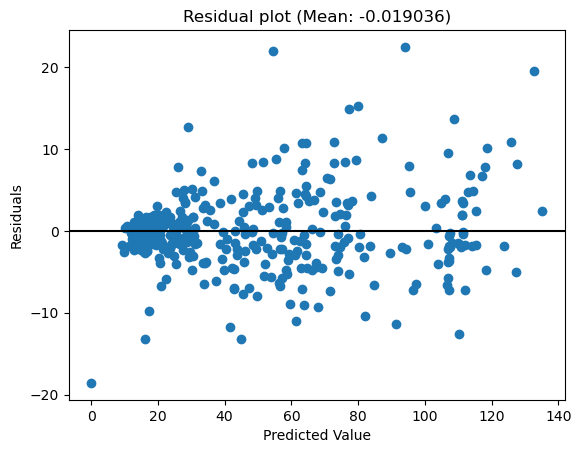

In [16]:
plt.scatter(x = pred_values, y= np.subtract(pred_values,data['Price']))
plt.axhline(y=0, color='black')
plt.title(f"Residual plot (Mean: {np.round(np.subtract(pred_values,data['Price']).mean(),6)})")
plt.ylabel('Residuals')
plt.xlabel('Predicted Value')
plt.show()

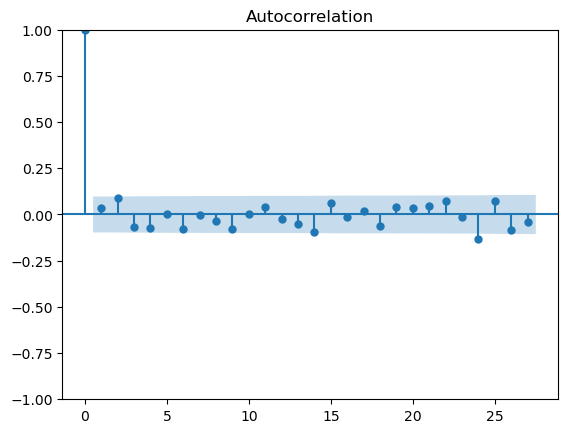

array([ 1.        ,  0.03597083,  0.0892553 , -0.06785179, -0.07400346,
        0.00125268, -0.07817927, -0.00452911, -0.03575762, -0.07811972,
        0.00260035,  0.0417115 , -0.02475876, -0.051451  , -0.09416494,
        0.06168623, -0.01566745,  0.01885756, -0.05983927,  0.04150195,
        0.03345189,  0.04818483,  0.07268301, -0.01467894, -0.13266022,
        0.07090432, -0.08407236])

In [17]:
plot_acf(np.subtract(pred_values,data['Price']))
plt.show()
acf(np.subtract(pred_values,data['Price']))

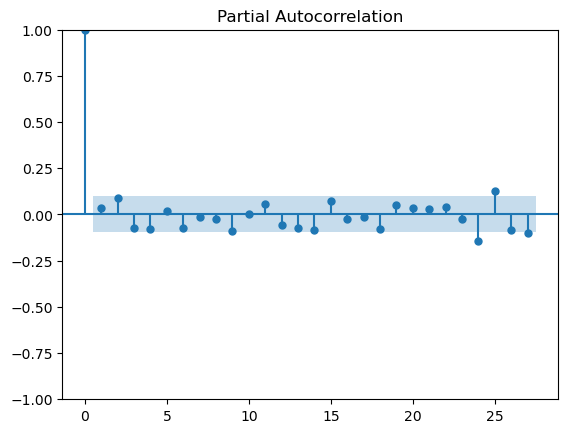

array([ 1.        ,  0.03605987,  0.08851304, -0.07518416, -0.07864809,
        0.02021096, -0.07216266, -0.01245121, -0.02638801, -0.08790961,
        0.00181259,  0.05583403, -0.05442935, -0.07468258, -0.0845543 ,
        0.07271209, -0.02189549, -0.0143487 , -0.08015113,  0.05240388,
        0.03749483,  0.03156495,  0.0414962 , -0.02457356, -0.14424843,
        0.12669089, -0.0866656 ])

In [18]:
plot_pacf(np.subtract(pred_values,data['Price']))
plt.show()
pacf(np.subtract(pred_values,data['Price']))

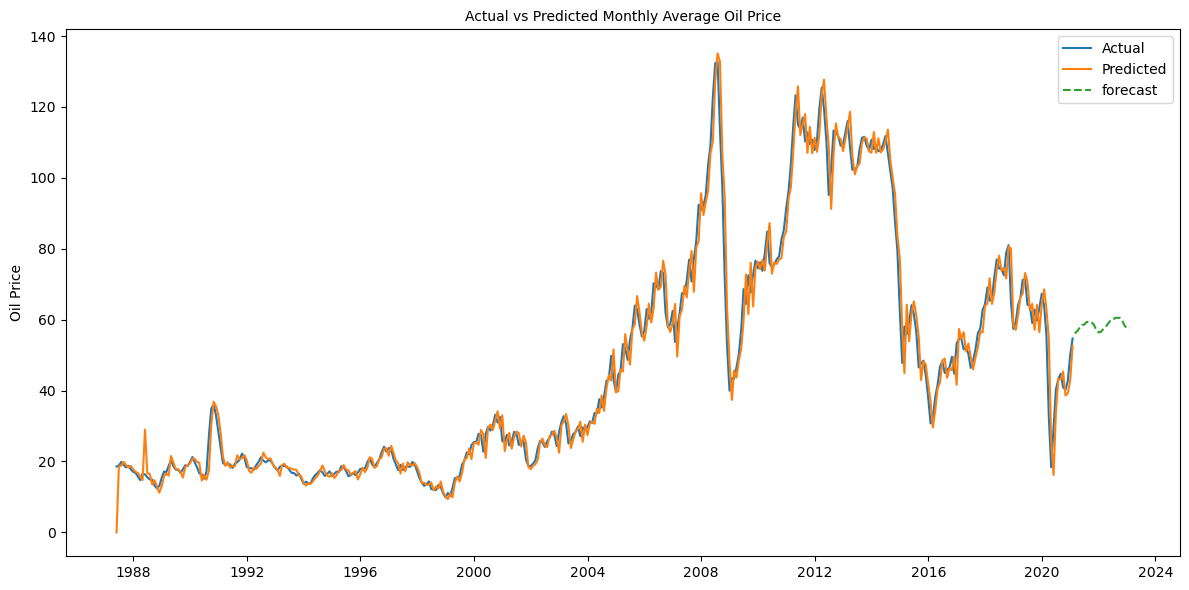

In [19]:
plt.figure(figsize=(12,6))
plt.plot(data, label='Actual')
plt.title('Actual vs Predicted Monthly Average Oil Price', fontsize=10)
pred_data = pd.DataFrame({'Date':data.reset_index()['Date'],'Price': pd.Series(pred_values.reset_index(drop=True))})
pred_data['Date'] = pd.to_datetime(pred_data['Date'])
pred_data = pred_data.set_index('Date')
plt.plot(pred_data, label='Predicted')
forecast_data = reg.forecast(24)
plt.plot(forecast_data, label='forecast',linestyle='--')
plt.legend(loc='best')
plt.ylabel("Oil Price")
plt.tight_layout()